In [1]:
import time
import numpy as np
try:
    import tqdm
except ImportError:
    tqdm = None

import matplotlib.pyplot as plt
from numpy import log, exp, sqrt

Nq=2
massinv = np.eye(Nq)
massinv[0,0] = 1.0 / 1
massinv[1,1] = 1.0 / 1

In [2]:
def create_p(Nq):
    p = np.random.normal(loc=0, scale=1.0, size=Nq) 
    return p

def Kp(p):
    '''Compute Kp, as M is identical matrix. '''
    return  0.5 * p.T @ (massinv @p) 
    #return 0.5 * np.dot(p, p.T)

### 1. HMC sampler

In [3]:
"""
This package implements the No-U-Turn Sampler (NUTS) algorithm 6 from the NUTS
paper (Hoffman & Gelman, 2011).

Content
-------

The package mainly contains:
  nuts6                     return samples using the NUTS
  test_nuts6                example usage of this package

and subroutines of nuts6:
  build_tree                the main recursion in NUTS
  find_reasonable_epsilon   Heuristic for choosing an initial value of epsilon
  leapfrog                  Perfom a leapfrog jump in the Hamiltonian space
  stop_criterion            Compute the stop condition in the main loop


A few words about NUTS
----------------------

Hamiltonian Monte Carlo or Hybrid Monte Carlo (HMC) is a Markov chain Monte
Carlo (MCMC) algorithm that avoids the random walk behavior and sensitivity to
correlated parameters, biggest weakness of many MCMC methods. Instead, it takes
a series of steps informed by first-order gradient information.

This feature allows it to converge much more quickly to high-dimensional target
distributions compared to simpler methods such as Metropolis, Gibbs sampling
(and derivatives).

However, HMC's performance is highly sensitive to two user-specified
parameters: a step size, and a desired number of steps.  In particular, if the
number of steps is too small then the algorithm will just exhibit random walk
behavior, whereas if it is too large it will waste computations.

Hoffman & Gelman introduced NUTS or the No-U-Turn Sampler, an extension to HMC
that eliminates the need to set a number of steps.  NUTS uses a recursive
algorithm to find likely candidate points that automatically stops when it
starts to double back and retrace its steps.  Empirically, NUTS perform at
least as effciently as and sometimes more effciently than a well tuned standard
HMC method, without requiring user intervention or costly tuning runs.

Moreover, Hoffman & Gelman derived a method for adapting the step size
parameter on the fly based on primal-dual averaging.  NUTS can thus be used
with no hand-tuning at all.

In practice, the implementation still requires a number of steps, a burning
period and a stepsize. However, the stepsize will be optimized during the
burning period, and the final values of all the user-defined values will be
revised by the algorithm.

reference: arXiv:1111.4246
"The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte
Carlo", Matthew D. Hoffman & Andrew Gelman
"""

__all__ = ['nuts6']

def leapfrog(theta, r, grad, epsilon, f):
    """ Perfom a leapfrog jump in the Hamiltonian space
    INPUTS
    ------
    theta: ndarray[float, ndim=1]
        initial parameter position

    r: ndarray[float, ndim=1]
        initial momentum

    grad: float
        initial gradient value

    epsilon: float
        step size

    f: callable
        it should return the log probability and gradient evaluated at theta
        logp, grad = f(theta)

    OUTPUTS
    -------
    thetaprime: ndarray[float, ndim=1]
        new parameter position
    rprime: ndarray[float, ndim=1]
        new momentum
    gradprime: float
        new gradient
    logpprime: float
        new lnp
    """
    # make half step in r
    rprime = r + 0.5 * epsilon * grad
    # make new step in theta
    #thetaprime = theta + epsilon * rprime
    thetaprime = theta + epsilon * massinv @ rprime
    #compute new gradient
    logpprime, gradprime = f(thetaprime)
    # make half step in r again
    rprime = rprime + 0.5 * epsilon * gradprime
    return thetaprime, rprime, gradprime, logpprime


def find_reasonable_epsilon(theta0, grad0, logp0, f):
    """ Heuristic for choosing an initial value of epsilon """
    epsilon = 1.
    r0 = np.random.normal(0., 1., len(theta0))

    # Figure out what direction we should be moving epsilon.
    _, rprime, gradprime, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
    # brutal! This trick make sure the step is not huge leading to infinite
    # values of the likelihood. This could also help to make sure theta stays
    # within the prior domain (if any)
    k = 1.
    while np.isinf(logpprime) or np.isinf(gradprime).any():
        k *= 0.5
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon * k, f)

    epsilon = 0.5 * k * epsilon

    # acceptprob = np.exp(logpprime - logp0 - 0.5 * (np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
    # a = 2. * float((acceptprob > 0.5)) - 1.
    #logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
    logacceptprob = logpprime-logp0-(Kp(rprime)-Kp(r0))
    a = 1. if logacceptprob > np.log(0.5) else -1.
    # Keep moving epsilon in that direction until acceptprob crosses 0.5.
    # while ( (acceptprob ** a) > (2. ** (-a))):
    while a * logacceptprob > -a * np.log(2):
        epsilon = epsilon * (2. ** a)
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
        # acceptprob = np.exp(logpprime - logp0 - 0.5 * ( np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
        #logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
        logacceptprob = logpprime-logp0-(Kp(rprime)-Kp(r0))

    print("find_reasonable_epsilon=", epsilon)

    return epsilon


def stop_criterion(thetaminus, thetaplus, rminus, rplus):
    """ Compute the stop condition in the main loop
    dot(dtheta, rminus) >= 0 & dot(dtheta, rplus >= 0)

    INPUTS
    ------
    thetaminus, thetaplus: ndarray[float, ndim=1]
        under and above position
    rminus, rplus: ndarray[float, ndim=1]
        under and above momentum

    OUTPUTS
    -------
    criterion: bool
        return if the condition is valid
    """
    dtheta = thetaplus - thetaminus
    return (np.dot(dtheta, rminus.T) >= 0) & (np.dot(dtheta, rplus.T) >= 0)


def build_tree(theta, r, grad, logu, v, j, epsilon, f, joint0):
    """The main recursion."""
    if (j == 0):
        # Base case: Take a single leapfrog step in the direction v.
        thetaprime, rprime, gradprime, logpprime = leapfrog(theta, r, grad, v * epsilon, f)
        #joint = logpprime - 0.5 * np.dot(rprime, rprime.T)
        joint = logpprime - Kp(rprime)
        # Is the new point in the slice?
        nprime = int(logu < joint)
        # Is the simulation wildly inaccurate?
        sprime = int((logu - 1000.) < joint)
        # Set the return values---minus=plus for all things here, since the
        # "tree" is of depth 0.
        thetaminus = thetaprime[:]
        thetaplus = thetaprime[:]
        rminus = rprime[:]
        rplus = rprime[:]
        gradminus = gradprime[:]
        gradplus = gradprime[:]
        # Compute the acceptance probability.
        alphaprime = min(1., np.exp(joint - joint0))
        #alphaprime = min(1., np.exp(logpprime - 0.5 * np.dot(rprime, rprime.T) - joint0))
        nalphaprime = 1
    else:
        # Recursion: Implicitly build the height j-1 left and right subtrees.
        thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime = build_tree(theta, r, grad, logu, v, j - 1, epsilon, f, joint0)
        # No need to keep going if the stopping criteria were met in the first subtree.
        if (sprime == 1):
            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaminus, rminus, gradminus, logu, v, j - 1, epsilon, f, joint0)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaplus, rplus, gradplus, logu, v, j - 1, epsilon, f, joint0)
            # Choose which subtree to propagate a sample up from.
            if (np.random.uniform() < (float(nprime2) / max(float(int(nprime) + int(nprime2)), 1.))):
                thetaprime = thetaprime2[:]
                gradprime = gradprime2[:]
                logpprime = logpprime2
            # Update the number of valid points.
            nprime = int(nprime) + int(nprime2)
            # Update the stopping criterion.
            sprime = int(sprime and sprime2 and stop_criterion(thetaminus, thetaplus, rminus, rplus))
            # Update the acceptance probability statistics.
            alphaprime = alphaprime + alphaprime2
            nalphaprime = nalphaprime + nalphaprime2

    return thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime



In [4]:
def nuts6(f, M, Madapt, q, delta=0.6, progress=False):
    """
    Implements the No-U-Turn Sampler (NUTS) algorithm 6 from from the NUTS
    paper (Hoffman & Gelman, 2011).

    Runs Madapt steps of burn-in, during which it adapts the step size
    parameter epsilon, then starts generating samples to return.

    Note the initial step size is tricky and not exactly the one from the
    initial paper.  In fact the initial step size could be given by the user in
    order to avoid potential problems

    INPUTS
    ------
    epsilon: float
        step size
        see nuts8 if you want to avoid tuning this parameter

    f: callable
        it should return the log probability and gradient evaluated at theta
        logp, grad = f(theta)

    M: int
        number of samples to generate.

    Madapt: int
        the number of steps of burn-in/how long to run the dual averaging
        algorithm to fit the step size epsilon.

    q: ndarray[float, ndim=1]
        initial guess of the parameters.

    KEYWORDS
    --------
    delta: float
        targeted acceptance fraction

    progress: bool
        whether to show progress (requires tqdm module for full functionality)

    OUTPUTS
    -------
    samples: ndarray[float, ndim=2]
    M x D matrix of samples generated by NUTS.
    note: samples[0, :] = theta0
    """

    if len(np.shape(q)) > 1:
        raise ValueError('q is expected to be a 1-D array')

    samples = []
    lnprob_list = []
    logp, grad = f(q)   
    lnprob = logp

    # Choose a reasonable first epsilon by a simple heuristic.  Algorithm 4
    epsilon = find_reasonable_epsilon(q, grad, logp, f)

    # Parameters to the dual averaging algorithm.
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    mu = log(10. * epsilon)

    # Initialize dual averaging algorithm.
    epsilonbar = 1
    Hbar = 0

    #for m in progress_range(1, 1000000, progress=progress):
    for m in range(1, 1000000):
        if len(samples) >= M + Madapt:
            break
        
        p = create_p(Nq)   

        #joint = logp - 0.5 * np.dot(p, p.T)
        joint = logp - Kp(p)
        
        # resample u ~ uniform([0, exp(joint)])
        logu = float(joint - np.random.exponential(1, size=1))

        # initialize the tree
        p_left, p_right = p, p
        q_left, q_right = q, q
        grad_left, grad_right = grad, grad
        
        j = 0 # initial height  
        n = 1
        s = 1 # will keep going until s == 0

        while s == 1:
            # choose a direction -1 = backwards, 1 = forwards
            #v = random.uniform(-1,1)
            v = int(2 * (np.random.uniform() < 0.5) - 1)

            # double the size of the tree
            if v == -1:
                q_left, p_left, grad_left, _,_,_, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = build_tree(q_left, p_left, grad_left, logu, v, j, epsilon, f, joint)
            else:
                _, _, _, q_right, p_right, grad_right, q_new, grad_new, logp_new, n_new, s_new, alpha, nalpha = build_tree(q_right, p_right, grad_right, logu, v, j, epsilon, f, joint)
            
            _tmp = min(1, float(n_new)/float(n))
            if s_new == 1 and (np.random.uniform() < _tmp):
                q = q_new
                lnprob = logp_new
                
                logp = logp_new
                grad = grad_new
                
                samples.append(q)
                lnprob_list.append(lnprob)

            # update  number of valid points we've seen
            n = n + n_new
            # decide if it's time to stop
            s = s_new and stop_criterion(q_left, q_right, p_left, p_right)
            # increment depth
            j = j+1      

        # Do adaptation of epsilon if we're still doing burn-in
        eta = 1 / float(m + t0)
        Hbar = (1 - eta) * Hbar + eta * (delta - alpha / float(nalpha))
        if m <= Madapt:
            epsilon = np.exp(mu - np.sqrt(m) / gamma * Hbar)
            eta = m ** -kappa
            epsilonbar = np.exp((1 - eta) * np.log(epsilonbar) + eta * np.log(epsilon))
        else:
            epsilon = epsilonbar

    print(m,Madapt,len(samples))
    print('Discrepancies between the realized average acceptance probability statistic h and its target = {}'.format(Hbar))
    samples = np.array(samples)[Madapt:,:]
    lnprob_list = lnprob_list[Madapt:]
        
    return samples, lnprob_list, epsilon


#### 1.2 Choose function

In [5]:
## fucntion 1
def f1(q):
    return logp1(q), grad1(q)

def logp1(q):
    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])


def grad1(q):
    grad = np.zeros(2)
    grad[0] = -q[0]*q[1]**2 + q[0] - 4
    grad[1] = -q[1]*q[0]**2 + q[1] - 4   
    return grad


def target_density1(q):
    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))


## fucntion 2
def f2(q):
    return logp2(q), grad2(q)

def logp2(q):
    return -0.5 * (q[0]**2 + q[1]**2)


def grad2(q):
    grad = np.zeros(2)
    grad[0] = -q[0] 
    grad[1] = -q[1]    
    return grad


def target_density2(q):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * (q[0]**2 + q[1]**2))

### 2. Visualization

#### 2.1 posterior density distribution and true distribution

In [6]:
def plot_prediction(samples, target_density=target_density1, save_file=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2], height_ratios=[2, 2], wspace=0.15, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    # generate grids
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)

    # compute the posterior density
    Z = target_density([X,Y])

    # plot samples

    ax1.plot(samples[:, 0], samples[:, 1], 'r+')
    # plot contour
    contour = plt.contour(X, Y, Z, cmap='viridis')
    ax1.clabel(contour, inline=1, fontsize=10)
    ax1.annotate(f'#Samples: {len(samples)}', xy=(5, 5), xytext=(5, 5),
                       ha='center', va='bottom')


    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_xlabel("x-samples")
    ax2.set_ylabel("density")
    data = samples[:,0]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax2.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax2.hist(data, bins=20,color='k',edgecolor='k',density=True, alpha=0.5)
    ax2.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax2.xaxis.set_tick_params(labelleft=False)


    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3.set_ylabel("y-samples")
    ax3.set_xlabel("density")
    data = samples[:,1]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax3.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax3.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True, orientation='horizontal')
    ax3.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax3.yaxis.set_tick_params(labelleft=False)

    ax_blank = fig.add_subplot(gs[1, 1])
    ax_blank.axis('off')

    plt.tight_layout()
    plt.savefig(save_file)

#### 2.2 Convergency speed

1. ACF(Autocorrelation Function) 自相关函数是一个用于评估样本独立性和质量的一个重要工具：\
如果ACF快速下降到零，说明样本之间的独立性较高；
反之，样本之间存在较高的自相关性，样本独立性较低。
2. ACF 可以用来计算有效样本大小（Effective Samples Size, ESS)，其计算公式为 $ESS = M/\tau$，其中M是总样本数，$\tau$是集成自相关时间（integrated autocorrelation time），其定义为: \
   $\tau = 1+2*\sum_{k=1}^{M_{cutoff}} (1- \frac{s}{M}) \rho_k$; $M_{cutoff} = min s$, $s.t. \rho < 0.05$ \
   $\rho = \frac{1}{\sigma^2 (M-s)} \sum_{m=s+1}^{M}(f(\theta^m)-\mu)(f(\theta^{m-s})-\mu)$
   where $\sigma^2$ is the mean of f and $\mu$ is the variance of f

In [7]:
def autocorrelation(chain, lag):
    M = len(chain)
    mean = np.mean(chain)
    var = np.sum((chain - mean) ** 2) / M
    return np.sum((chain[:M-lag] - mean) * (chain[lag:] - mean)) / (M - lag) / var

def autocorrelation_function(chain, max_lag):
    return np.array([autocorrelation(chain, lag) for lag in range(max_lag)])

def integrated_autocorrelation_time(autocorr, M):
    # Use a cutoff when autocorrelation lower than 0.05
    cuttoff_autocorr = autocorr[autocorr > 0.05]
    M_cutoff = len(cuttoff_autocorr)

    sum = 0
    for s in range(M_cutoff):
        sum += cuttoff_autocorr[s] * (1 - s/M)
    
    return 1 + 2 * sum

def effective_sample_size(chain, max_lag):
    M = len(chain)
    autocorr = autocorrelation_function(chain, max_lag)
    tau = integrated_autocorrelation_time(autocorr, M)
    ess = M / tau
    return ess 

# 可视化自相关函数
def plot_autocorrelation(chain, max_lag, label,save_file=None):
    fig = plt.figure(figsize=(10, 10))
    autocorr = autocorrelation_function(chain, max_lag)
    lags = np.arange(max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, autocorr, linefmt='lightblue')
    plt.xlabel('Lag')
    plt.ylabel(f'{label} Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.axhline(y=0.05, color='g', linestyle='--', linewidth=1)
    plt.axhline(y=-0.05, color='g', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.savefig(save_file)


#### 2.3 Log likelihood function, truth value and predicted mean value

In [8]:
def plot_loglikelihood(A, alpha, save_file=None):
    fig = plt.figure(figsize=(10, 10))
    #plt.figure(1)
    alpha = 0
    # Print Monte-Carlo estimate of alpha.
    print("Mean:  " + str(np.mean(A)))
    per = np.percentile(A, [16, 50, 84])
    print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

    n, b = np.histogram(A, 30)
    x = 0.5 * (b[:-1] + b[1:])
    y = n.astype(float) / n.sum()
    plt.step(x, y, color='b', lw=3, where='mid')


    ylim = plt.ylim()
    plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
    plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)
    plt.ylim(ylim)
    plt.xlabel(r'$\alpha$', fontsize=24)
    plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)
    plt.savefig(save_file)

# Initialization

For each method, we drew 5000 sample safter 1000 burn-in samples.

In [9]:
Nq = 2
q0 = np.random.normal(0, 1, Nq)


massinv = np.eye(Nq)
massinv[0,0] = 1.0 / 1
massinv[1,1] = 1.0 / 1

n_samples = 5000
n_adapt = 1000

delta = 0.2   # mean acceptance probability


f=f2

t_start = time.time()

print('Running HMC with dual averaging and trajectory length %0.2f...' % delta)
samples, lnprob, epsilon = nuts6(f, n_samples, n_adapt, q0, delta)
print('Done. Final epsilon = %f.' % epsilon)

t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))



Running HMC with dual averaging and trajectory length 0.20...
find_reasonable_epsilon= 2.0
41725 1000 6000
Discrepancies between the realized average acceptance probability statistic h and its target = 0.05794292092965418
Done. Final epsilon = 2.376842.
Sampling Completed in 1.21 seconds


# Visualization

/var/folders/st/h8zl89fn7f7gj0l06p3q5wj40000gn/T/ipykernel_28245/3411569975.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Mean:  -0.013796167963702104
Alpha = -0.04263532911834106 (+1.0908965237647186 / - 1.0099974340093363)
Mean:  0.002960262691520905
Alpha = 0.004652915152292325 (+1.0207216529252574 / - 1.0302569510606947)
Effective Sample Size (ESS): 1423.9085170388921
Effective Sample Size (ESS): 1413.3974285145018


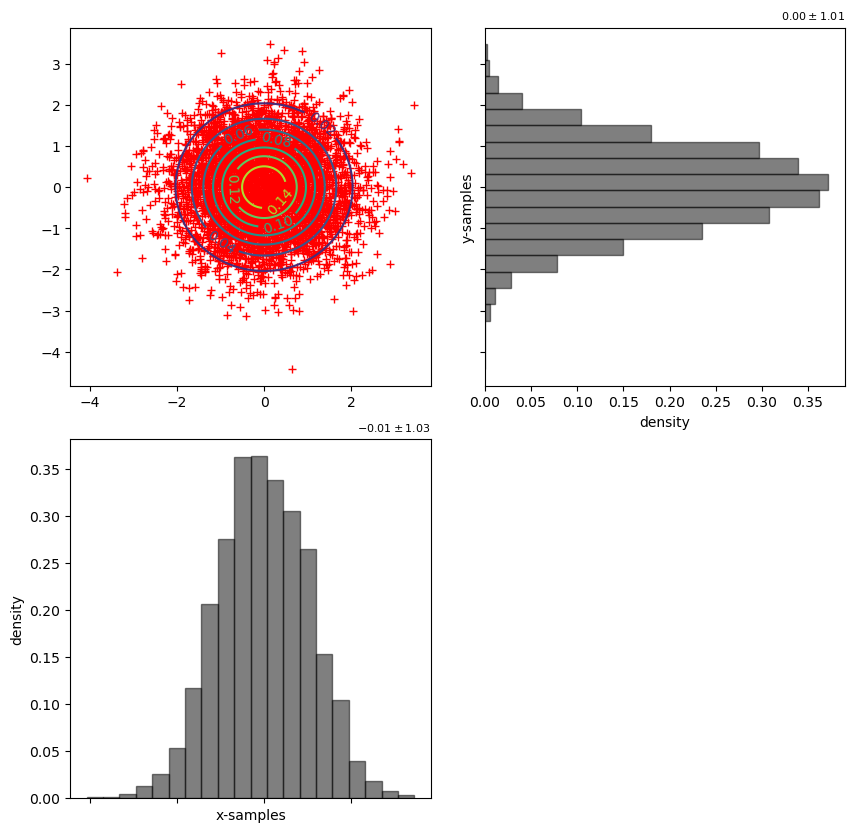

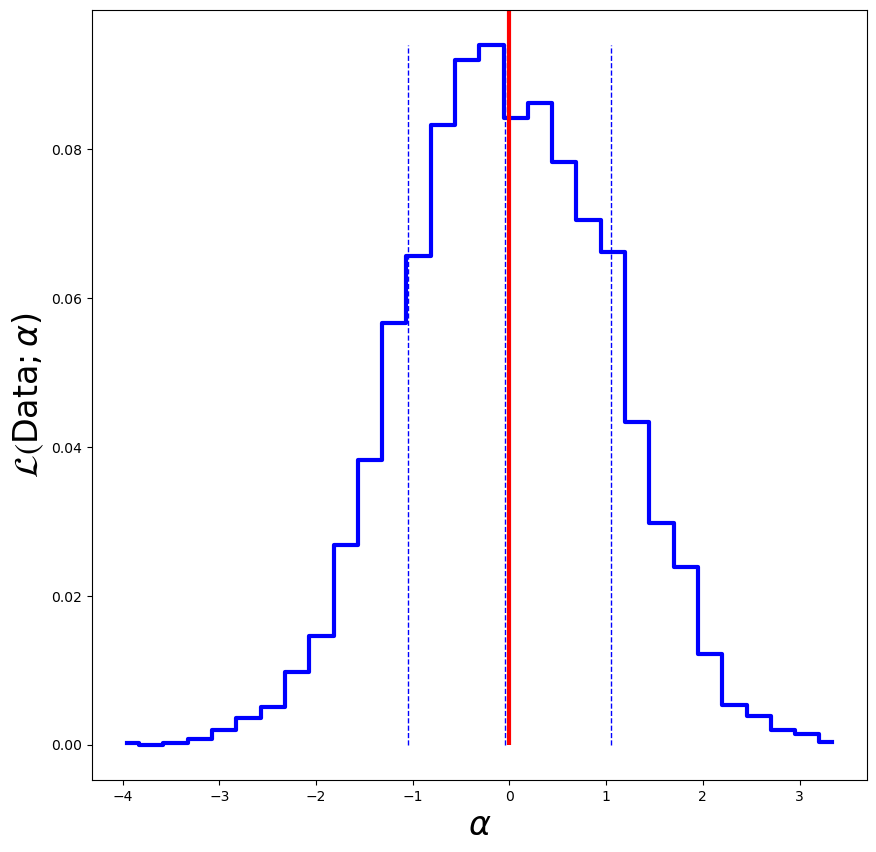

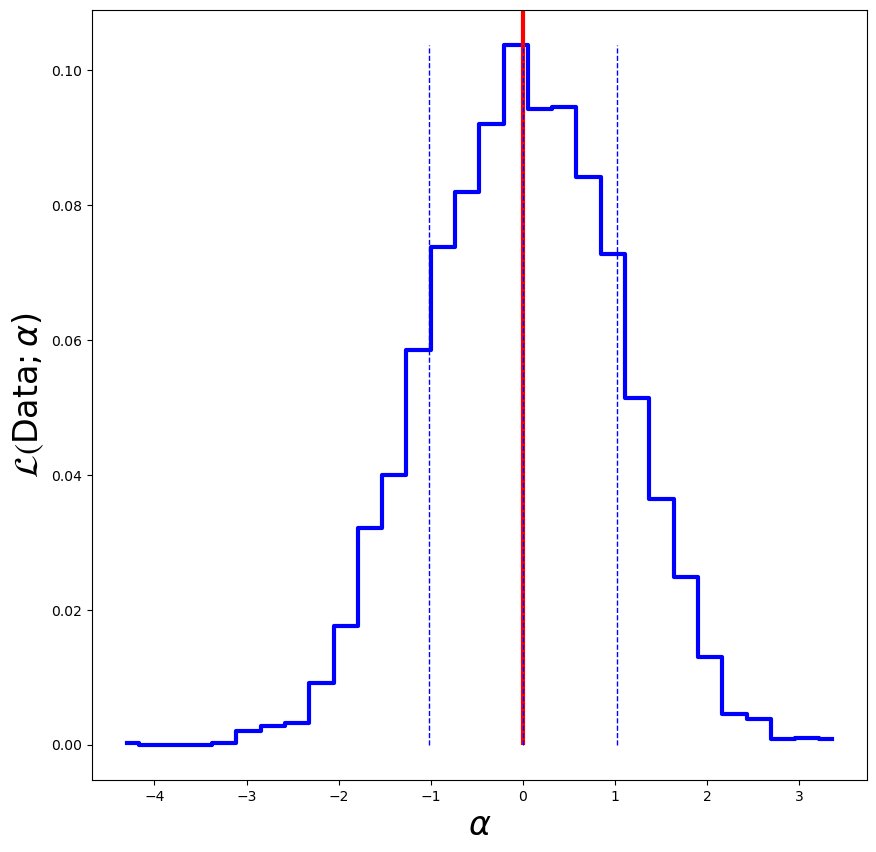

<Figure size 1000x1000 with 0 Axes>

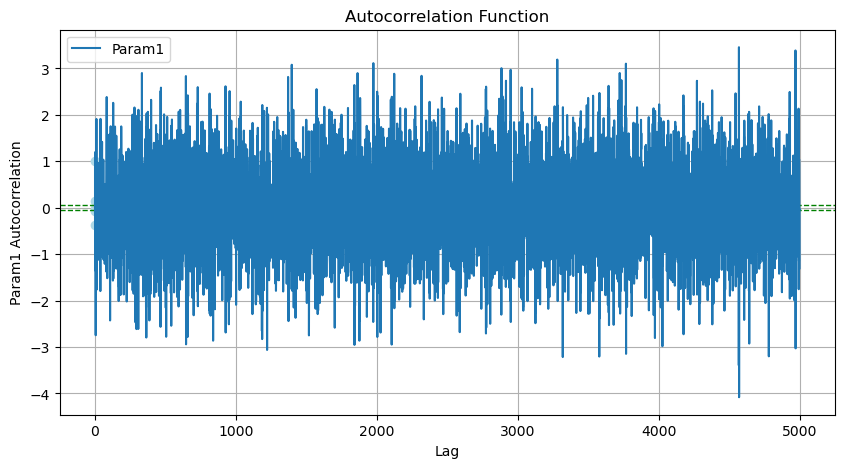

<Figure size 1000x1000 with 0 Axes>

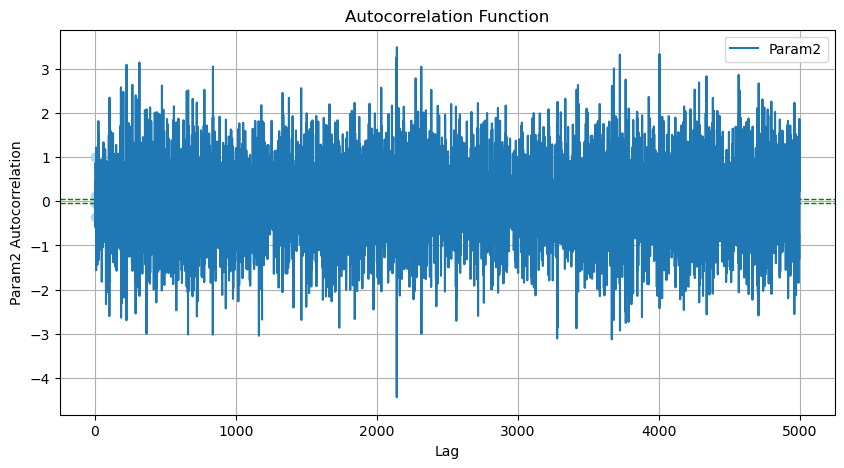

In [13]:

# visualization
plot_prediction(samples, target_density2, save_file = '/Users/gangyang/Desktop/figs/1.png')
plot_loglikelihood(samples[:,0], 1, save_file = '/Users/gangyang/Desktop/figs/2.png')

plot_loglikelihood(samples[:,1], 1, save_file = '/Users/gangyang/Desktop/figs/3.png')

# 最大滞后时间
max_lag = 1000

#  parameter 1
data = samples[:,0]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param1', save_file = '/Users/gangyang/Desktop/figs/4.png')
plt.plot(data, label='Param1')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/5.png')


#  parameter 2
data = samples[:,1]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param2', save_file = '/Users/gangyang/Desktop/figs/6.png')

#### sample trace plot for a signle run
plt.plot(data, label='Param2')
plt.legend()
plt.savefig('/Users/gangyang/Desktop/figs/7.png')

In [11]:
a = 0.009
a >= 0

True

In [12]:
int(0>-1)

1